In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import scipy as sp
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from collections import defaultdict
import re
import sklearn.feature_extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing
import time
stemmer =  SnowballStemmer(language='english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alejandro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alejandro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def int_to_en(num):
    d = { 0 : 'zero', 1 : 'one', 2 : 'two', 3 : 'three', 4 : 'four', 5 : 'five',
          6 : 'six', 7 : 'seven', 8 : 'eight', 9 : 'nine', 10 : 'ten',
          11 : 'eleven', 12 : 'twelve', 13 : 'thirteen', 14 : 'fourteen',
          15 : 'fifteen', 16 : 'sixteen', 17 : 'seventeen', 18 : 'eighteen',
          19 : 'nineteen', 20 : 'twenty',
          30 : 'thirty', 40 : 'forty', 50 : 'fifty', 60 : 'sixty',
          70 : 'seventy', 80 : 'eighty', 90 : 'ninety' }
    k = 1000
    m = k * 1000
    b = m * 1000
    t = b * 1000

    assert(0 <= num)

    if (num < 20):
        return d[num]

    if (num < 100):
        if num % 10 == 0: return d[num]
        else: return d[num // 10 * 10] + '-' + d[num % 10]

    if (num < k):
        if num % 100 == 0: return d[num // 100] + ' hundred'
        else: return d[num // 100] + ' hundred and ' + int_to_en(num % 100)

    if (num < m):
        if num % k == 0: return int_to_en(num // k) + ' thousand'
        else: return int_to_en(num // k) + ' thousand, ' + int_to_en(num % k)

    if (num < b):
        if (num % m) == 0: return int_to_en(num // m) + ' million'
        else: return int_to_en(num // m) + ' million, ' + int_to_en(num % m)
        
    if (num < t):
        if (num % b) == 0: return int_to_en(num // b) + ' billion'
        else: return int_to_en(num // b) + ' billion, ' + int_to_en(num % b)

    if (num % t == 0): return int_to_en(num // t) + ' trillion'
    else: return int_to_en(num // t) + ' trillion, ' + int_to_en(num % t)

    raise AssertionError('num is too large: %s' % str(num))

### Data

In [3]:
train_df = pd.read_csv("quora_train_data.csv")
test_df = pd.read_csv("quora_test_data.csv")

In [4]:
train_df.shape, test_df.shape

((323432, 6), (80858, 6))

### All questions (data variable)

In [5]:
# Train set
all_q1_train = list(train_df["question1"])
all_q2_train = list(train_df["question2"])
all_questions_train = all_q1_train + all_q2_train
len(all_questions_train)

646864

### Is_duplicate (target variable)

In [6]:
y_train = train_df["is_duplicate"].values
y_test = test_df['is_duplicate'].values
len(y_train), len(y_test)

(323432, 80858)

### List of questions into strings

In [7]:
print(set(type(x).__name__ for x in all_questions_train))

{'str', 'float'}


In [8]:
def cast_list_as_strings(mylist):
    """
    return a list of strings
    """
    assert isinstance(mylist, list), f"the input mylist should be a list it is {type(mylist)}"
    
    # return list(map(lambda x: str(x), all_questions)) # Slower
    return [str(s) for s in mylist]

In [9]:
all_questions_train = cast_list_as_strings(all_questions_train)
print(set(type(x).__name__ for x in all_questions_train))

{'str'}


# A) CountVectorizers

## 1. Sklearn CountVectorizer

In [10]:
count_vect = CountVectorizer()
sk_vect = count_vect.fit(all_questions_train)
sk_vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [11]:
def get_features_from_df(df, vectorizer):
    """
    returns a sparse matrix containing the features build by the count vectorizer.
    Each row should contain features from question1 and question2.
    """
    q1_casted =  cast_list_as_strings(list(df["question1"]))
    q2_casted =  cast_list_as_strings(list(df["question2"]))
    
    q1 = vectorizer.transform(q1_casted)
    q2 = vectorizer.transform(q2_casted)
    
    X_q1q2 = scipy.sparse.hstack((q1,q2))
        
    return X_q1q2

In [12]:
X_tr_q1q2 = get_features_from_df(train_df,count_vect)
X_te_q1q2  = get_features_from_df(test_df, count_vect)

X_tr_q1q2.shape, X_te_q1q2.shape

((323432, 156550), (80858, 156550))

In [13]:
logistic = LogisticRegression(solver="liblinear",verbose=1, max_iter=100)
logistic.fit(X_tr_q1q2, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [14]:
acc_train_0 = logistic.score(X_tr_q1q2, y_train)
acc_test_0 = logistic.score(X_te_q1q2, y_test)
acc_train_0 , acc_test_0

(0.811954290237206, 0.7536050854584581)

## 2. Simple CountVectorizer

In [15]:
class SimpleCountVectorizer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    
    def __init__(self,
                 min_word_counts=1,
                 doc_cleaner_pattern=r"[^a-zA-Z]",
                 token_pattern=r"(?u)\b\w\w+\b",
                 dtype=np.float32,
                 doc_cleaner_func=None,
                 tokenizer_func=None,
                 word_transformer_func=None):
        
        self._retype = type(re.compile('hello, world'))

        self.min_word_counts     = min_word_counts
        self.doc_cleaner_pattern = doc_cleaner_pattern
        self.token_pattern       = token_pattern
        self.dtype               = dtype
        
        self.doc_cleaner_func      = doc_cleaner_func
        self.tokenizer_func        = tokenizer_func
        self.word_transformer_func = word_transformer_func

        self.vocabulary = set()
        self.word_to_ind = {}


    def build_doc_cleaner(self, lower=True):
        """
        Returns a function that cleans undesirable substrings in a string.
        It also lowers the input string if lower=True
        """
        if self.doc_cleaner_func:
            return self.doc_cleaner_func
        else:
            if isinstance(self.doc_cleaner_pattern, self._retype):
                #clean_doc_pattern = self.doc_cleaner_pattern.sub(" ", doc)
                clean_doc_pattern = re.compile(self.doc_cleaner_pattern)
            else:
                clean_doc_pattern = re.compile(self.doc_cleaner_pattern)

            if lower:
                 return lambda doc: clean_doc_pattern.sub(" ", doc).lower()
            else:
                 return lambda doc: clean_doc_pattern.sub(" ", doc)

    def build_tokenizer(self):
        """Returns a function that splits a string into a sequence of tokens"""
        if self.tokenizer_func:
            return self.tokenizer_func
        
        else:
            token_pattern = re.compile(self.token_pattern)
            return lambda doc: token_pattern.findall(doc)

    def build_word_transformer(self):
        """Returns a stemmer or lemmaitzer if object has any"""
        
        if self.word_transformer_func:
            return self.word_transformer_func
        else:
            return lambda word: word
        
    def tokenize(self, doc):
        doc_cleaner      = self.build_doc_cleaner()
        doc_tokenizer    = self.build_tokenizer()
        doc     = doc_cleaner(doc)
        words = doc_tokenizer(doc)
            
        return words
        
    def fit(self, X):

        assert self.vocabulary == set(), "self.vocabulary is not empty it has {} words".format(len(self.vocabulary))
        assert isinstance(X,list), "X is expected to be a list of documents"
        
        i = 0
        word_to_ind = {}
        doc_cleaner      = self.build_doc_cleaner()
        doc_tokenizer    = self.build_tokenizer()
        word_transformer = self.build_word_transformer()
        
        for x in X:
            words = doc_cleaner(x)
            words = doc_tokenizer(words)
            for word in words:
                if word not in word_to_ind:
                    word_to_ind[word] = i
                    i += 1
        self.word_to_ind = word_to_ind
        self.n_features = len(word_to_ind)    
                
        self.vocabulary = set(word_to_ind.keys())
                
        return self
    
    def transform(self, X, memory_efficient=False):
        
        doc_cleaner      = self.build_doc_cleaner()
        doc_tokenizer    = self.build_tokenizer()
        word_transformer = self.build_word_transformer()      
        
        col_indices = []
        row_indices = []
        sp_data     = []
                
        if memory_efficient:
            for m, x in enumerate(X):  
                words = doc_cleaner(x)
                words = doc_tokenizer(words)
                for word in words: 
                    index = self.word_to_ind[word]
                    
                    col_indices.append(index)
                    row_indices.append(m)
                    sp_data.append(1)
                    
            encoded_X = sp.csr_matrix((sp_data, (row_indices, col_indices)), shape = (len(X) ,self.n_features)) 
                        
        else:
            
            encoded_X = np.zeros((len(X), len(self.word_to_ind)))
            for m, x in enumerate(X):  
                words = doc_cleaner(x)
                words = doc_tokenizer(words)
                for word in words: 
                    index = self.word_to_ind[word]
                    encoded_X[m, index] += 1
        
        return encoded_X
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        encoded_X = self.transform(X)
        return encoded_X
    
    def _words_in_vocab(self, X):
        
        if isinstance(X, str):
            return [w for w in self.tokenize(X) if w in self.vocabulary]
        
        X_words_in_vocab = []
        for sentence in X:
            X_words_in_vocab.append(self.tokenize(sentence))
            
        return X_words_in_vocab

In [16]:
def num_conv(s):
    try:
        return int_to_en(int(s)).replace(",","").replace(" ","_")
    except:
        return s


def my_doc_cleaner(doc,
                  pat=r"[^a-zA-Z0-9]"):
    # Allow alphanumeric characters
    doc_cleaner_pattern=pat
    clean_doc_pattern = re.compile(doc_cleaner_pattern)
    doc_clean = clean_doc_pattern.sub(" ", doc)
    return doc.lower()


# stpw = set(stopwords.words("english"))
stpw = []

stemmer =  SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def my_tokenizer_func(doc, 
                      ngrams=(1,3), 
                      numbers_to_words=True,
                      stop_words=stpw,
                      pat=r"(?u)\b\w\S*\w*\b",
                      lem=True,
                      stem=True):
    
    # Split using a patterm
#     pat=r"(?u)\b\w\w+\b"
#     pat=r"(?u)\b\w\S*\w*\b"
    token_pattern = re.compile(pat)
    lst = token_pattern.findall(doc)
    
    # Transform numbers into words
    if numbers_to_words:
        lst = list(map(lambda x: num_conv(x), lst))
        
    # Drop stopwords 
    lst = list(filter(lambda x : x not in stop_words, lst))
    
    #Stemmer
    if stem:
        lst = list(map(lambda x: stemmer.stem(x), lst))
    
    #Lemmatizer 
    if lem:
        lst = list(map(lambda x: lemmatizer.lemmatize(x), lst))
        
    if ngrams==(1,1):
        return lst
    
    # Generate ngrams
    lstRet = []
    for a in range(ngrams[0], ngrams[1]+1):
        if a!=1:
            lstRet+=list(zip(*[lst[i:] for i in range(a)]))
    return lstRet if ngrams[0]!=1 else lst+lstRet

In [17]:
count_vect_simple = SimpleCountVectorizer(
    doc_cleaner_func=my_doc_cleaner,
    tokenizer_func=my_tokenizer_func
)
simple_vect = count_vect_simple.fit(all_questions_train)
simple_vect

SimpleCountVectorizer(doc_cleaner_func=<function my_doc_cleaner at 0x0000020C8F02E400>,
                      doc_cleaner_pattern='[^a-zA-Z]',
                      dtype=<class 'numpy.float32'>, min_word_counts=1,
                      token_pattern='(?u)\\b\\w\\w+\\b',
                      tokenizer_func=<function my_tokenizer_func at 0x0000020C8F02E488>,
                      word_transformer_func=None)

In [18]:
#X_tr_q1q2_simple = get_features_from_df(train_df, count_vect_simple)
#X_te_q1q2_simple  = get_features_from_df(test_df, count_vect_simple)

#X_tr_q1q2_simple.shape, X_te_q1q2_simple.shape

In [19]:
#logistic.fit(X_tr_q1q2_simple, y_train)

In [20]:
#acc_train_1 = logistic.score(X_tr_q1q2_simple, y_train)
#acc_test_1 = logistic.score(X_te_q1q2_simple, y_test)
#acc_train_1 , acc_test_1

In [21]:
acc_train_1 = 0.9963670879813995
acc_test_1 = 0.8085285314996661

# B) TfidfVectorizers

## 1. Sklearn TfidfVectorizer

In [22]:
tfidf_vectorizer = TfidfVectorizer()
sk_tfidf = tfidf_vectorizer.fit(all_questions_train)
sk_tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [23]:
X_tfidf_tr_q1q2 = get_features_from_df(train_df, tfidf_vectorizer)
X_tfidf_te_q1q2  = get_features_from_df(test_df, tfidf_vectorizer)

X_tfidf_tr_q1q2.shape, X_tfidf_te_q1q2.shape

((323432, 156550), (80858, 156550))

In [24]:
logistic.fit(X_tfidf_tr_q1q2, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [25]:
acc_train_2 = logistic.score(X_tfidf_tr_q1q2, y_train)
acc_test_2 = logistic.score(X_tfidf_te_q1q2, y_test)
acc_train_2 , acc_test_2

(0.7935763931831111, 0.7578347226001138)

## 2. Simple TfidfVectorizer

In [26]:
class SimpleTFIDFVectorizer():
    
    def __init__(self, vocabulary, word_to_ind, tokenize, normalize_tf=True, normalize_tfidf=True):
        self.tokenize = tokenize
        self.vocabulary = vocabulary
        self.word_to_ind = word_to_ind
        self.n_features = len(word_to_ind)
        self.normalize_tf = normalize_tf
        self.normalize_tfidf = normalize_tfidf
        self.X_w = None
        self.idf = None
        self.n_documents = None
    
    def fit(self, X):
        """
        Fit TFID vectorizer to a certain corpus of documents X
        """
        assert isinstance(X,list), "You should pass a list"
        
        t1 = time.time()
        self.__build_vocabulary(X)
        self.n_documents = len(X)
        self.__compute_idf()
        print('TFIDF fit finished in',str(round(time.time()-t1, 2)),'seconds')
        
    def transform(self, X):
        """
        Transform a corpus X to its TFID vectorization
        """
        assert self.X_w is not None and self.idf is not None and self.n_documents is not None,'Fit must be performed first'
        assert isinstance(X,list), "You should pass a list"
        
        t1 = time.time()
        col_indices = []
        row_indices = []
        sp_data     = []
        
        encoded_X = None # Create an encoded_X
        for m, doc in enumerate(X):
#             print(m)
            words = self.tokenize(doc)
            for w in words:
                if w in self.word_to_ind:
                    index = self.word_to_ind[w]
                    col_indices.append(index)
                    row_indices.append(m)
                    sp_data.append(1)
#             print(doc, normalize_tf)
#             print(len(doc))
#             tf = self.__term_frequency(doc, normalize_tf)
#             tfidf = tf.multiply(self.idf)
#             if normalize_tfidf: tfidf = tfidf/sp.sparse.linalg.norm(tfidf)
#             encoded_X = sp.vstack((encoded_X, tf)) if encoded_X is not None else tfidf
        encoded_X = sp.sparse.csr_matrix((sp_data, (row_indices, col_indices)), shape=(len(X), self.n_features))
        if self.normalize_tf: encoded_X = sklearn.preprocessing.normalize(encoded_X, axis=1)
        
        encoded_X = encoded_X.multiply(self.idf)
        if self.normalize_tfidf: encoded_X = sklearn.preprocessing.normalize(encoded_X, axis=1)
        
        print('TFIDF transform finished in',str(round(time.time()-t1, 2)),'seconds')
        return encoded_X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def __build_vocabulary(self, corpus):
        """
        This function builds X_w, a dict containing for each key, how
        many documents having that key are in our corpus.
        """
        X_w = {}

        for document in corpus:
            words = self.tokenize(document)
            for word in words:
                if word not in X_w: X_w[word] = 1
                else: X_w[word] += 1

        self.X_w = X_w
        
    def __compute_idf(self):
        col_indices = []
        row_indices = []
        sp_data     = []

        for w in self.X_w:
            docs_present = self.X_w[w]
            index = self.word_to_ind[w]
            col_indices.append(index)
            row_indices.append(0)
            sp_data.append( np.log(self.n_documents / (1 + docs_present)) )

        self.idf = sp.sparse.csr_matrix((sp_data, (row_indices, col_indices)), shape=(1, self.n_features))

    def __term_frequency(self, document, normalize=True):
        
        words = self.tokenize(document)
        col_indices = []
        row_indices = []
        sp_data     = []

        for w in words:
            if w in self.word_to_ind:
                index = self.word_to_ind[w]
                col_indices.append(index)
                row_indices.append(0)
                sp_data.append(1)
        
        tf = sp.sparse.csr_matrix((sp_data, (row_indices, col_indices)), shape=(1, self.n_features))
        
        if normalize:
            return tf.multiply(1/sp.sparse.linalg.norm(tf))
        else:
            return tf

In [27]:
tfidf_simple = SimpleTFIDFVectorizer(count_vect_simple.vocabulary, count_vect_simple.word_to_ind, count_vect_simple.tokenize)
simple_tfidf = tfidf_simple.fit(all_questions_train)
simple_tfidf

TFIDF fit finished in 786.86 seconds


In [28]:
X_tfidf_simple_tr_q1q2 = get_features_from_df(train_df, tfidf_simple)
X_tfidf_simple_te_q1q2  = get_features_from_df(test_df, tfidf_simple)

X_tfidf_simple_tr_q1q2.shape, X_tfidf_simple_te_q1q2.shape

TFIDF transform finished in 442.36 seconds
TFIDF transform finished in 486.21 seconds
TFIDF transform finished in 103.72 seconds
TFIDF transform finished in 107.24 seconds


((323432, 6166022), (80858, 6166022))

In [29]:
logistic.fit(X_tfidf_simple_tr_q1q2, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [30]:
acc_train_3 = logistic.score(X_tfidf_simple_tr_q1q2, y_train)
acc_test_3 = logistic.score(X_tfidf_simple_te_q1q2, y_test)
acc_train_3 , acc_test_3

(0.9006870068515175, 0.7897919810037349)

# C) Comparing results

In [31]:
df_results = pd.DataFrame()
df_results["Sklearn Countvectorizer"]   = [acc_train_0, acc_test_0]
df_results["Simple Countvectorizer"]  = [acc_train_1, acc_test_1]
df_results["Sklearn TfidfVectorizer"] = [acc_train_2, acc_test_2]
df_results["Simple TfidfVectorizer"] = [acc_train_3, acc_test_3]
df_results.index=["train","test"] 

In [32]:
df_results

,Sklearn Countvectorizer,Simple Countvectorizer,Sklearn TfidfVectorizer,Simple TfidfVectorizer
train,0.811954,0.996367,0.793576,0.900687
test,0.753605,0.808529,0.757835,0.789792


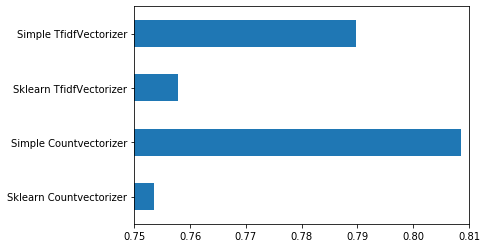

In [38]:
%matplotlib inline
df_results.T["test"].plot(kind="barh", xlim=(0.75,0.81))

In [35]:
X_tr_q1q2.shape, X_te_q1q2.shape, #X_tr_q1q2_simple.shape, X_te_q1q2_simple.shape

((323432, 156550), (80858, 156550))

In [36]:
X_tfidf_tr_q1q2.shape, X_tfidf_te_q1q2.shape, X_tfidf_simple_tr_q1q2.shape, X_tfidf_simple_te_q1q2.shape

((323432, 156550), (80858, 156550), (323432, 6166022), (80858, 6166022))